# Capstone Project

## Background

We are glad you have successfully reached the capstone project part of "Data Science Fundamentals" course. You will put everything 
you have learned so far about data science to work. The outcome of this module should potentially serve as your portfolio item.

Unlike with previous projects, this time you are free to choose a dataset to explore from three suggested ones. As you will have to solve a provided problem, there will not be list of predefined questions that you have to answer - be creative and explore any dimensions of data you deem worth analyzing.

Although this might seem scary, this is how data science looks like in the industry. Often, it's your responsibility to not only give answers using the data, but also raise questions. The more creatively you look at this project, the better. Good luck!

----

## Requirements

Whichever problem you choose to analyze, general requirements are as follow:

#### Exploratory Data Analysis
* Describe the data with basic statistical parameters - mean, median, quantiles, etc. Use parameters that give you the most important statistical insights of the data.
* Grouping the data and analyzing the groups - using Pandas aggregate methods.
* Work with features - handle missing data if needed, use pandas date APIs.
* Manipulate datasets - use joins in needed.
* Visualize the data - you can use line, scatter, histogram plots, density plots, regplots, etc.

#### Statistical hypothesis testing
* Use at least one statistical significance test.
* Report p-values.
* Use visualizations.

#### Modeling
* Visualize data with dimensionality reduction algorithms.
* Perform cluster analysis.
* Use a linear model to explain relationships and predict new values.

#### Presentation
* Present the project - the data, methods and results.

# 2016 US presidential elections

<div><img width="400px" height="auto" src="https://images.unsplash.com/photo-1583340806569-6da3d5ea9911?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=1315&q=80" /></div>

In 2016, Donald Trump lost the popular vote, yet he won the electoral vote, securing 4 years in the Oval Office. This has been a shock to democrat supporters all around the world.

Imagine you travel back in time to 2016. As soon as you step out of your time-capsule, the Democratic Party hires you. They want you, the best data scientist across the time and space, **to explain what happened and what should have been done differently**. They want you to **prepare them for 2020 presidential elections**.

The Party has some tips for you - inspect the voters. What are Trump supporters? What do they feature? What are our supporters? Where should focus next? Any pro-trump states? Cities?

The Democrats were kind of enough to share [a Kaggle dataset](https://www.kaggle.com/benhamner/2016-us-election) with you on 2016 U.S. elections. Use the data to help the Democrats.

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In 2016, Hillary received 48.2% of the popular vote, Trump received 46.1% and won. However, he didn't just win, he won handily, with 304 to Hillary's 227 electoral votes. In other words, a 1.9% difference in Hillary's favour turned into a 14.3% difference in favor to Donald. How does something like this happen?

Put in a somewhat oversimplified way, people are not the relevant actors in a presidential election in USA, states are. States choose electors, electors vote in the president.

Every state receives a number of electors based on their population, but also a minimum of 3 electors simply for being a state. This is largely where the discrepancy comes in, and makes the votes of voters in less populated states worth more per voter.

So, in order to win, should the Democrats focus on getting voters in the "best value" states? Not quite.

The election system is first past the post, meaning that whoever receives the majority in a state receives *all* of the state's elector votes1 - the votes of Republicans in California matter about as much as the votes of Democrats in Texas, which is to say not at all. Thus, gaining more voters does literally nothing unless there are enough of them in the same state to outvote the other party.

So what does this mean for our analysis? We're looking for swing states - states that are not already locked in to one candidate or the other - and we are looking to find out just how swingy they are, what the proportion of hardcore supporters of a party or candidate there are in a state, and what proportion of one are voters that might be persuaded.

1 shennanigans and voting districts notwithstanding

We also have an issue with the dataset that the Democrats have provided us. The election data given is of the 2016 primary elections, the means by which each of the parties (and, perhaps quixotically, some Independents) determine internally which exact candidate of theirs they want to represent them in the election, rather than which party wins the election.

We want to know what makes people vote Democrat over Republican. The primaries can only tell us which Democrat from other Democrats or which Republican from other Republicans people prefer.

While the primary results will help us identify hardcore supporters, we're going to need a dataset with the actual 2016 election to be able to form any kind of bigger picture.

Finally, each state is free to determine how exactly it picks its electors, which means there are institutional factors to consider when evaluating the results. The main ways these are determined are:

* Primaries
* Open caucuses
* Closed caucuses

Presidential election dataset [from MIT](https://doi.org/10.7910/DVN/VOQCHQ).

In [40]:
pe = pd.read_csv("https://github.com/DaumantasL/Turing-Files/blob/main/countypres_2000-2016.csv?raw=true") #presidential elections 2012-2016

cf = pd.read_csv("https://github.com/DaumantasL/Turing-Files/raw/main/county_facts.csv") #county facts
cfdict = pd.read_csv("https://github.com/DaumantasL/Turing-Files/raw/main/county_facts_dictionary.csv") #county facts dictionary

electoral_college = pd.read_csv("https://raw.githubusercontent.com/DaumantasL/Turing-Files/main/Electoral_College.csv") #elector count by state and year

##EDA: Data cleaning

###County facts dataset

Check for null values in county facts datamframe.

In [41]:
cf.shape

(3195, 54)

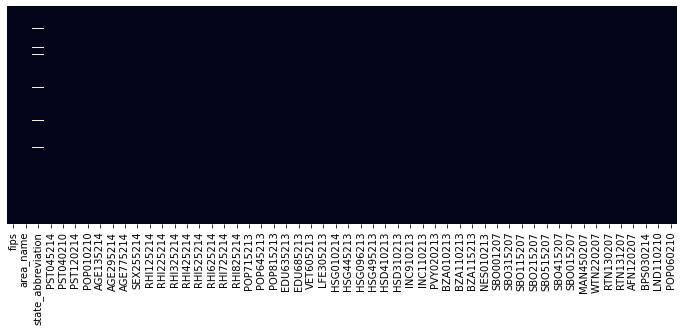

In [42]:
plt.figure(figsize=(12,4))
sns.heatmap(cf.isnull(), cbar=False, xticklabels=True, yticklabels=False)

In [43]:
cf[cf["state_abbreviation"].isnull()].head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,0,United States,NaN,318857056,308758105,3.3,308745538,6.2,23.1,14.5,50.8,77.4,13.2,1.2,5.4,0.2,2.5,17.4,62.1,84.9,12.9,20.7,86.0,28.8,21263779,25.5,133957180,64.9,26.0,176700,115610216,2.63,28155,53046,15.4,7488353,118266253,2.0,23005620,27092908,7.1,0.9,5.7,0.1,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,Alabama,NaN,4849377,4780127,1.4,4779736,6.1,22.8,15.3,51.5,69.7,26.7,0.7,1.3,0.1,1.5,4.1,66.2,85.0,3.5,5.2,83.1,22.6,388865,24.2,2207912,69.7,15.9,122500,1838683,2.55,23680,43253,18.6,97578,1603100,1.1,311578,382350,14.8,0.8,1.8,0.1,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
69,2000,Alaska,NaN,736732,710249,3.7,710231,7.4,25.3,9.4,47.4,66.9,3.9,14.8,6.1,1.3,7.1,6.8,61.9,80.3,7.0,16.2,91.6,27.5,71004,18.8,308583,63.8,24.0,241800,251899,2.75,32651,70760,9.9,20519,266627,3.3,52991,68728,1.5,10.0,3.1,0.3,0.0,25.9,8204030,4563605,9303387,13635,1851293,1518,570640.95,1.2
99,4000,Arizona,NaN,6731484,6392310,5.3,6392017,6.4,24.1,15.9,50.3,83.7,4.7,5.3,3.3,0.3,2.7,30.5,56.2,80.4,13.4,26.8,85.7,26.9,522382,24.6,2909218,64.4,20.7,165100,2370289,2.67,25358,49774,17.9,132762,2173205,1.8,420233,491529,2.0,1.9,3.3,0.0,10.7,28.1,57977827,57573459,86758801,13637,13268514,26997,113594.08,56.3
115,5000,Arkansas,NaN,2966369,2915958,1.7,2915918,6.5,23.8,15.7,50.9,79.7,15.6,1.0,1.5,0.3,1.9,7.0,73.4,83.6,4.5,7.2,83.7,20.1,237311,21.3,1341033,66.7,15.7,107300,1129723,2.53,22170,40768,19.2,64772,978094,0.0,191530,238994,5.5,1.1,1.4,0.1,2.3,24.5,60735582,29659789,32974282,11602,3559795,7666,52035.48,56.0


The only missing values in the county facts dataframe are for pre-existing rows of aggregate data by state. We'll make a copy of state-level data for later use since it's a mix of information that might be difficult to aggregate on our own and then remove it from our main dataframe.

In [44]:
states = cf[cf["state_abbreviation"].isnull()].copy()
states = states[states["area_name"] != "United States"] #exclude nation-level data from state dataframe
states.replace(to_replace="District Of Columbia", value="District of Columbia", inplace=True)
cf = cf[ ~cf["state_abbreviation"].isnull() ]

We have a lot of difficulty interpreting column names. Lets prepare a dictionary to make them readable when needed.

In [45]:
cfdict = cfdict.set_index('column_name').T.to_dict('list')

###Presidential election dataset

Select the relevant year from the presidential election dataframe and check for empty values.

In [46]:
pe.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208,20191203
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208,20191203
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203


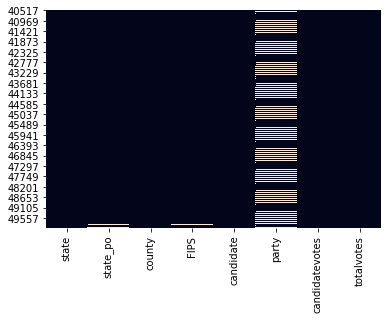

In [47]:
pe = pe[(pe["year"]==2016) & (pe["office"]=="President") ]
pe = pe.drop(labels = ["year", "office", "version"], axis=1)
sns.heatmap(pe.isnull(), cbar=False)

In [48]:
pe.head()

,state,state_po,county,FIPS,candidate,party,candidatevotes,totalvotes
40517,Alabama,AL,Autauga,1001.0,Hillary Clinton,democrat,5936.0,24973
40518,Alabama,AL,Autauga,1001.0,Donald Trump,republican,18172.0,24973
40519,Alabama,AL,Autauga,1001.0,Other,NaN,865.0,24973
40520,Alabama,AL,Baldwin,1003.0,Hillary Clinton,democrat,18458.0,95215
40521,Alabama,AL,Baldwin,1003.0,Donald Trump,republican,72883.0,95215


In [49]:
pe["state_po"].nunique()

51

The state_po column is an abbreviation of the state name (and Washington D.C., which is not technically a state but participates in presidential election regardless).
As such, it has no unique information and we are free to drop it.

In [50]:
pe = pe.drop(labels="state_po", axis=1)

In [51]:
pe[pe.party.isnull()].head()

,state,county,FIPS,candidate,party,candidatevotes,totalvotes
40519,Alabama,Autauga,1001.0,Other,NaN,865.0,24973
40522,Alabama,Baldwin,1003.0,Other,NaN,3874.0,95215
40525,Alabama,Barbour,1005.0,Other,NaN,144.0,10469
40528,Alabama,Bibb,1007.0,Other,NaN,207.0,8819
40531,Alabama,Blount,1009.0,Other,NaN,573.0,25588


In [52]:
pe[pe.party.isnull()].candidate.value_counts()

Other    3158
Name: candidate, dtype: int64

The only cases where a party value is missing is when the votes are for a third party candidate - or an independent. There are cases where a distinction between third party candidates and independent candidates may matter, but not when our primary analysis is of differences between Hilary and Donald.

We'll treat NaN values in the party column as Other.

In [53]:
pe.party = pe.party.fillna("Other")

Look at remaining missing values.

In [54]:
pe[pe.isnull().any(axis=1)]

,state,county,FIPS,candidate,party,candidatevotes,totalvotes
49178,Virginia,Bedford,51515.0,Hillary Clinton,democrat,NaN,0
49179,Virginia,Bedford,51515.0,Donald Trump,republican,NaN,0
49180,Virginia,Bedford,51515.0,Other,Other,NaN,0
49859,Connecticut,Statewide writein,NaN,Hillary Clinton,democrat,NaN,5056
49860,Maine,Maine UOCAVA,NaN,Hillary Clinton,democrat,3017.0,5056
49861,Rhode Island,Federal Precinct,NaN,Hillary Clinton,democrat,637.0,5056
49862,Connecticut,Statewide writein,NaN,Donald Trump,republican,NaN,5056
49863,Maine,Maine UOCAVA,NaN,Donald Trump,republican,648.0,5056
49864,Rhode Island,Federal Precinct,NaN,Donald Trump,republican,53.0,5056
49865,Connecticut,Statewide writein,NaN,Other,Other,NaN,5056


In [55]:
pe[(pe["state"] == "Virginia") & (pe["county"] == "Bedford")]

,state,county,FIPS,candidate,party,candidatevotes,totalvotes
48917,Virginia,Bedford,51019.0,Hillary Clinton,democrat,9768.0,42525
48918,Virginia,Bedford,51019.0,Donald Trump,republican,30659.0,42525
48919,Virginia,Bedford,51019.0,Other,Other,2098.0,42525
49178,Virginia,Bedford,51515.0,Hillary Clinton,democrat,NaN,0
49179,Virginia,Bedford,51515.0,Donald Trump,republican,NaN,0
49180,Virginia,Bedford,51515.0,Other,Other,NaN,0


The vote data presented under FIPS (Federal Information Processing Standards, an american location census code system) 51019 matches that presented by the [Virginia Department of Elections](https://results.elections.virginia.gov/vaelections/2016%20November%20General/Site/Locality/BEDFORD%20COUNTY/Index.html), and FIPS 51515 seems to be a [legacy census code](https://www.ddorn.net/data/FIPS_County_Code_Changes.pdf) - it existing in this dataset at all is an oversight. We are free to drop these rows.

In [56]:
pe = pe[pe["FIPS"] != 51515]

Looks like the rest of our missing values are primarily due to non-existent FIPS values - this is due to the voters being grouped by some factor other than geographic - [overseas military personnel](https://www.maine.gov/sos/cec/elec/voter-info/uocava.html), [state-wide voting for candidates that are not on the ballot](https://en.wikipedia.org/wiki/Write-in_candidate), and so on.

There also seems to have been a mistake in the original dataset that grouped all these different groups of voters together, even though normally they would be associated with specific states.

In [57]:
pe[pe["totalvotes"] == 5056]

,state,county,FIPS,candidate,party,candidatevotes,totalvotes
49859,Connecticut,Statewide writein,NaN,Hillary Clinton,democrat,NaN,5056
49860,Maine,Maine UOCAVA,NaN,Hillary Clinton,democrat,3017.0,5056
49861,Rhode Island,Federal Precinct,NaN,Hillary Clinton,democrat,637.0,5056
49862,Connecticut,Statewide writein,NaN,Donald Trump,republican,NaN,5056
49863,Maine,Maine UOCAVA,NaN,Donald Trump,republican,648.0,5056
49864,Rhode Island,Federal Precinct,NaN,Donald Trump,republican,53.0,5056
49865,Connecticut,Statewide writein,NaN,Other,Other,NaN,5056
49866,Maine,Maine UOCAVA,NaN,Other,Other,321.0,5056
49867,Rhode Island,Federal Precinct,NaN,Other,Other,38.0,5056
50521,Alaska,District 99,2099.0,Hillary Clinton,democrat,274.0,5056


Our plan is to combine county-level voting data with county-level demographic data. We don't have demographic data easily available for these non-geographic groups, and the relatively small size of the vote results means that it will not be particularly worth it to try to retrieve demographic data about them through other channels.

Dropping the data is fine here.

In [58]:
pe = pe[pe["totalvotes"] != 5056]

pe[["FIPS", "candidatevotes"]] = pe[["FIPS", "candidatevotes"]].astype(int)

###Electoral college dataset

This is a supplemental dataset we only really need for the state-level elector count.

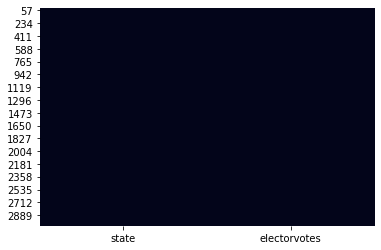

In [59]:
electoral_college = electoral_college[electoral_college["Year"]==2016]
electoral_college = electoral_college.drop("Year", 1)

electoral_college.replace("D.C.", value="District of Columbia", inplace=True)

electoral_college.Votes = electoral_college.Votes.astype(int)
electoral_college = electoral_college.rename(columns={"Votes": "electorvotes", "State": "state"})

sns.heatmap(electoral_college.isnull(), cbar=False)

###Dataset merge

Compare our two main dataframes.

In [60]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9459 entries, 40517 to 50520
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           9459 non-null   object
 1   county          9459 non-null   object
 2   FIPS            9459 non-null   int64 
 3   candidate       9459 non-null   object
 4   party           9459 non-null   object
 5   candidatevotes  9459 non-null   int64 
 6   totalvotes      9459 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 591.2+ KB


In [61]:
cf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 2 to 3194
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fips                3143 non-null   int64  
 1   area_name           3143 non-null   object 
 2   state_abbreviation  3143 non-null   object 
 3   PST045214           3143 non-null   int64  
 4   PST040210           3143 non-null   int64  
 5   PST120214           3143 non-null   float64
 6   POP010210           3143 non-null   int64  
 7   AGE135214           3143 non-null   float64
 8   AGE295214           3143 non-null   float64
 9   AGE775214           3143 non-null   float64
 10  SEX255214           3143 non-null   float64
 11  RHI125214           3143 non-null   float64
 12  RHI225214           3143 non-null   float64
 13  RHI325214           3143 non-null   float64
 14  RHI425214           3143 non-null   float64
 15  RHI525214           3143 non-null   float64
 16  RHI625

We have 9459 rows in our presidential election dataset, 3 per county for an effective 3153 lines, and 3143 in the other. Lets take a look at what the differences are.

In [62]:
print(set(cf["fips"]) ^ set(pe["FIPS"]))

{2026, 2030, 2010, 2012, 2014, 2018, 2032, 2022, 2024, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2011, 2015, 2017, 2019, 2021, 2023, 2025, 2027, 2028, 2029, 2031, 2033, 2034, 2037, 2035, 2040, 2050, 2036, 2060, 2038, 2039, 2068, 2070, 2090, 2100, 2105, 2110, 2122, 2130, 2150, 2164, 2170, 2180, 2185, 2188, 2195, 2198, 2220, 2230, 2240, 2261, 2270, 2275, 2282, 2290, 51515, 36000, 15005}


There seems to be a *lot* of differences in FIPS 020XXX, which is Alaska.

In [63]:
cf[cf["state_abbreviation"] == "AK"].head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
70,2013,Aleutians East Borough,AK,3360,3141,7.0,3141,2.8,10.1,6.6,30.9,22.8,12.0,20.5,40.7,0.6,3.4,13.2,11.5,77.4,56.6,63.7,78.5,12.0,99,4.8,747,54.7,15.7,118500,435,2.46,26535,61250,16.7,59,0,0.0,241,188,0.0,71.8,0.0,0.0,0.0,0.0,0,0,9326,3309,0,0,6981.94,0.4
71,2016,Aleutians West Census Area,AK,5750,5561,3.4,5561,3.6,12.3,5.4,32.4,37.8,7.6,13.0,34.5,2.3,4.7,14.1,26.9,81.5,34.9,47.4,82.7,13.3,354,6.4,1932,36.4,44.2,218400,1033,3.52,31790,81853,9.2,117,4668,1.9,254,285,0.0,0.0,0.0,0.0,0.0,26.3,634809,62073,46785,9823,14684,2,4390.28,1.3
72,2020,Anchorage Municipality,AK,301010,291826,3.1,291826,7.4,24.9,8.9,48.6,66.1,6.3,8.2,9.2,2.4,7.8,8.9,59.7,79.5,9.4,17.3,92.5,32.8,30292,19.4,114332,60.6,33.6,282800,105208,2.73,36214,77454,7.9,8609,152377,4.5,19252,26726,2.5,5.7,5.3,0.0,3.1,30.2,0,2914025,4482714,16096,933301,770,1704.68,171.2
73,2050,Bethel Census Area,AK,17868,17013,5.0,17013,11.1,36.1,6.6,48.3,12.1,0.8,81.7,1.1,0.2,4.1,1.8,11.5,85.2,1.2,66.7,79.5,11.7,909,7.4,5920,64.2,13.0,189600,4358,3.90,18497,51689,22.8,232,3174,0.3,1079,1238,0.0,54.7,0.0,0.0,0.0,20.8,0,3454,96755,5658,4091,11,40570.00,0.4
74,2060,Bristol Bay Borough,AK,957,997,-4.0,997,5.2,20.1,9.7,44.3,46.1,0.0,35.2,1.0,0.3,17.3,4.3,44.1,83.4,0.6,5.2,91.7,19.4,91,10.2,965,57.3,12.7,175000,384,2.42,37024,79531,7.9,66,299,-7.4,220,250,0.0,0.0,0.0,0.0,0.0,0.0,0,0,12785,12823,13278,2,503.84,2.0


In [64]:
pe[pe["state"] == "Alaska"].head()

,state,county,FIPS,candidate,party,candidatevotes,totalvotes
50401,Alaska,District 1,2001,Hillary Clinton,democrat,2573,6638
50402,Alaska,District 1,2001,Donald Trump,republican,3180,6638
50403,Alaska,District 1,2001,Other,Other,885,6638
50404,Alaska,District 2,2002,Hillary Clinton,democrat,1585,5492
50405,Alaska,District 2,2002,Donald Trump,republican,3188,5492


We can see that county and FIPS designations differ vastly between the two datasets. Why is this?

This is not a dataset error - it turns out [Alaska uses different geographical designations](https://www.elections.alaska.gov/Core/cityandboroughelections.php) for administrative versus election purposes.

This means state-wide aggregate data will still be accurate for Alaska, but we have no good way to link voting preferences to demographic data at the county level.

Lets check the remainder of our mismatches.

In [65]:
cf[cf["fips"].isin([15005, 36000, 51515])]

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
561,15005,Kalawao County,HI,89,90,-1.1,90,0.0,0.0,29.2,52.8,28.1,0.0,0.0,7.9,48.3,15.7,1.1,27.0,90.1,19.7,33.8,87.7,41.5,3,10.0,113,0.0,25.3,0,46,1.39,45515,59375,14.7,1,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,11.99,7.5
2964,51515,Bedford city,VA,0,0,0.0,6222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.5,2.1,3.9,86.3,25.0,641,18.7,0,58.7,27.6,146400,2800,2.07,22322,35593,18.7,315,3824,-11.5,387,589,8.6,0.0,0.0,0.0,0.0,24.9,0,28870,124881,19848,15426,0,6.88,904.6


In [66]:
pe[pe["FIPS"].isin([15005, 36000, 51515])]

,state,county,FIPS,candidate,party,candidatevotes,totalvotes
45911,Missouri,Kansas City,36000,Hillary Clinton,democrat,97735,128601
45912,Missouri,Kansas City,36000,Donald Trump,republican,24654,128601
45913,Missouri,Kansas City,36000,Other,Other,6212,128601


Bedford city is an outdated geographical designation as we already know, and Kalawao County is small enough population-wise that we do not mind dropping it from our analysis, but Missouri's Kansas City is too large to comfortably drop.

It is likely that the inclusion of Kansas City is a mistake - the FIPS of 36000 properly belongs to the state of New York, and Kansas City itself is not an electoral entity, and instead is spread over [three counties](https://www.nytimes.com/elections/2016/results/missouri) in Missouri.

We are free to drop it from our dataset as well.

In [67]:
cf.drop([561, 2964], inplace=True)
pe.drop([45911, 45912, 45913], inplace=True)

We'll drop rop rows of Other candidates - we'll be focusing on Trump and Hillary.

We'll also add some derived statistics to the election data. Most of these are self explanatory. The one exception to that is absolute margin - we care about that one because it's an easily trackable measure of how close an election is.

In [68]:
pe = pe[pe["party"] != "Other"]


pe["percentvotes"]= pe["candidatevotes"] / pe["totalvotes"]

margin_democrat = pe.loc[pe["party"] == "democrat", "percentvotes"].values - pe.loc[pe["party"] == "republican", "percentvotes"].values
pe.loc[pe["party"] == "democrat", "margin"] = margin_democrat

pe.loc[pe["party"] == "republican", "margin"] = -1*margin_democrat

pe = pe[pe["party"] != "Other"]

pe["absolutemargin"] = pe["margin"].abs()

pe.head()

,state,county,FIPS,candidate,party,candidatevotes,totalvotes,percentvotes,margin,absolutemargin
40517,Alabama,Autauga,1001,Hillary Clinton,democrat,5936,24973,0.237697,-0.489969,0.489969
40518,Alabama,Autauga,1001,Donald Trump,republican,18172,24973,0.727666,0.489969,0.489969
40520,Alabama,Baldwin,1003,Hillary Clinton,democrat,18458,95215,0.193856,-0.571601,0.571601
40521,Alabama,Baldwin,1003,Donald Trump,republican,72883,95215,0.765457,0.571601,0.571601
40523,Alabama,Barbour,1005,Hillary Clinton,democrat,4871,10469,0.465278,-0.055688,0.055688


Join the two datasets.

In [69]:
data = pe.merge(cf, left_on="FIPS", right_on="fips")
data = data.drop(["fips", "area_name", "state_abbreviation"], axis=1)

In [70]:
data.head()

,state,county,FIPS,candidate,party,candidatevotes,totalvotes,percentvotes,margin,absolutemargin,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,Alabama,Autauga,1001,Hillary Clinton,democrat,5936,24973,0.237697,-0.489969,0.489969,55395,54571,1.5,54571,6.0,25.2,13.8,51.4,77.9,18.7,0.5,1.1,0.1,1.8,2.7,75.6,85.0,1.6,3.5,85.6,20.9,5922,26.2,22751,76.8,8.3,136200,20071,2.71,24571,53682,12.1,817,10120,2.1,2947,4067,15.2,0.0,1.3,0.0,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
1,Alabama,Autauga,1001,Donald Trump,republican,18172,24973,0.727666,0.489969,0.489969,55395,54571,1.5,54571,6.0,25.2,13.8,51.4,77.9,18.7,0.5,1.1,0.1,1.8,2.7,75.6,85.0,1.6,3.5,85.6,20.9,5922,26.2,22751,76.8,8.3,136200,20071,2.71,24571,53682,12.1,817,10120,2.1,2947,4067,15.2,0.0,1.3,0.0,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
2,Alabama,Baldwin,1003,Hillary Clinton,democrat,18458,95215,0.193856,-0.571601,0.571601,200111,182265,9.8,182265,5.6,22.2,18.7,51.2,87.1,9.6,0.7,0.9,0.1,1.6,4.6,83.0,82.1,3.6,5.5,89.1,27.7,19346,25.9,107374,72.6,24.4,168600,73283,2.52,26766,50221,13.9,4871,54988,3.7,16508,19035,2.7,0.4,1.0,0.0,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
3,Alabama,Baldwin,1003,Donald Trump,republican,72883,95215,0.765457,0.571601,0.571601,200111,182265,9.8,182265,5.6,22.2,18.7,51.2,87.1,9.6,0.7,0.9,0.1,1.6,4.6,83.0,82.1,3.6,5.5,89.1,27.7,19346,25.9,107374,72.6,24.4,168600,73283,2.52,26766,50221,13.9,4871,54988,3.7,16508,19035,2.7,0.4,1.0,0.0,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,Alabama,Barbour,1005,Hillary Clinton,democrat,4871,10469,0.465278,-0.055688,0.055688,26887,27457,-2.1,27457,5.7,21.2,16.5,46.6,50.2,47.6,0.6,0.5,0.2,0.9,4.5,46.6,84.8,2.9,5.0,73.7,13.4,2120,24.6,11799,67.7,10.6,89200,9200,2.66,16829,32911,26.7,464,6611,-5.6,1546,1667,0.0,0.0,0.0,0.0,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0


##EDA: Preliminary analysis

###By county

In [71]:
data.shape

(6230, 61)

Our data has quite a few features, but we realistically only care about those that have a significant relationship with election results.

Lets take a quick view of what those might be.

First, we make a correlation matrix for all our numeric values for the democrat half of our dataset.

In [72]:
data_democrat_county = data[data["party"] == "democrat"].loc[:,'candidatevotes':'POP060210']
corr = data_democrat_county.corr()

Next, we make a corresponding matrix of Pearson's p-values.

In [73]:
from scipy.stats import pearsonr

In [74]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(data_democrat_county)
mask = np.invert( np.tril(p_values<=0.05) & (corr.abs()>=0.5) )

And finally, we display the correlation matrix, hiding any correlations that have p values above 0.05 and correlation coefficiens below 0.5.

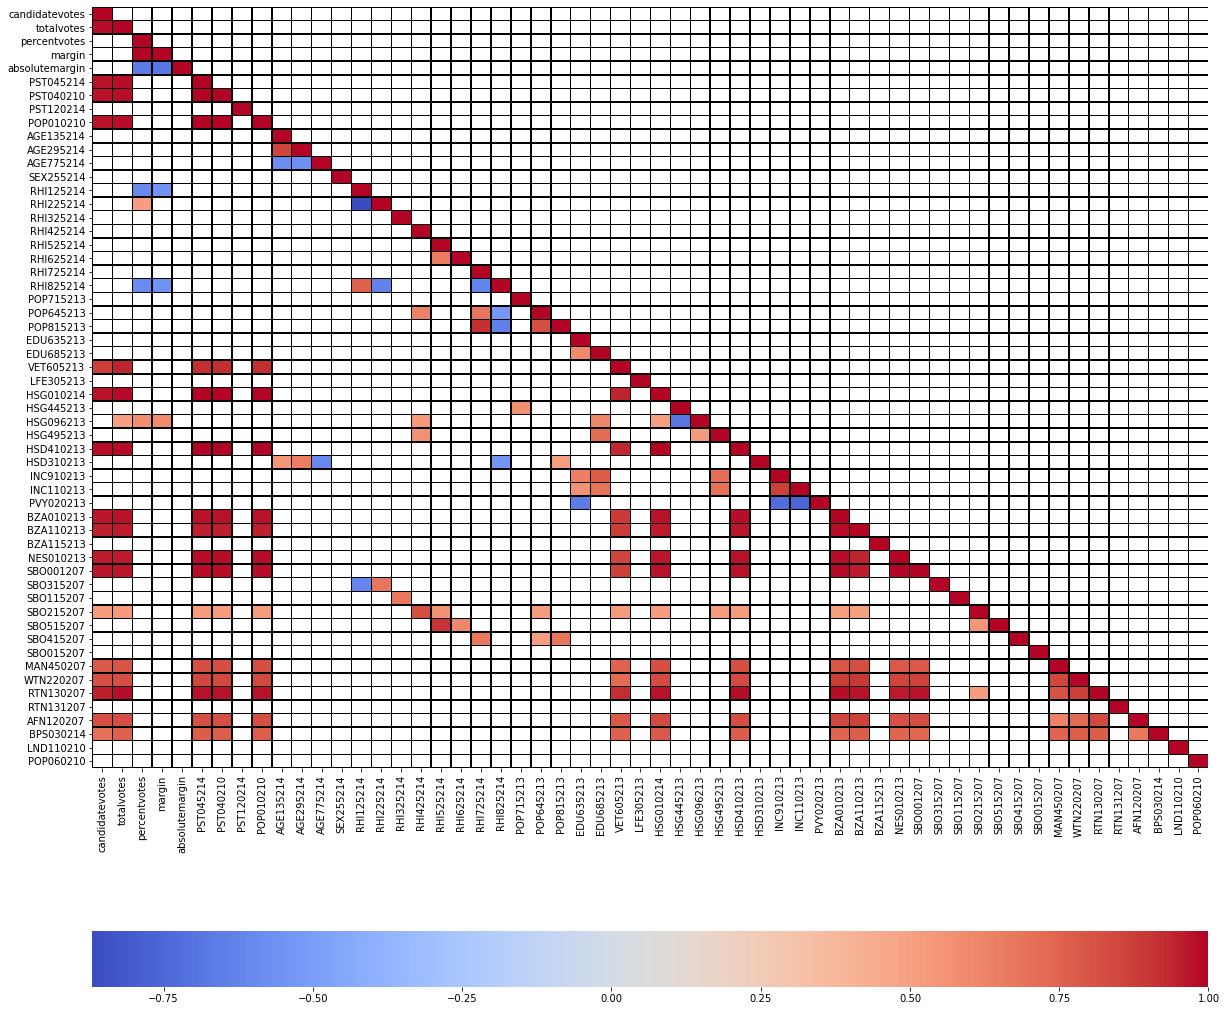

In [75]:
plt.figure(figsize=(20,20))
sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm', linewidths=0.5, linecolor='black', cbar_kws={'orientation': 'horizontal'})

The main values that we care about here are the percentage *margin* by which the democrats had won or lost, and the *absolute margin* of a loss in a location.

Sadly, for the latter one, we can not detect any strong and significant correlations. This means we can not easily identify swing voter demographic features.

We can at least determine a relationship between support for democrats and some demographic features.

In [76]:
corr = corr * (p_values<=0.05)
relevant_features = (corr.loc[corr["margin"].abs() >= 0.5, "margin"].index)
relevant_features = relevant_features[relevant_features.isin(cfdict.keys())]
[(x, cfdict[x]) for x in relevant_features]


[('RHI125214', ['White alone, percent, 2014']),
 ('RHI825214', ['White alone, not Hispanic or Latino, percent, 2014']),
 ('HSG096213', ['Housing units in multi-unit structures, percent, 2009-2013'])]

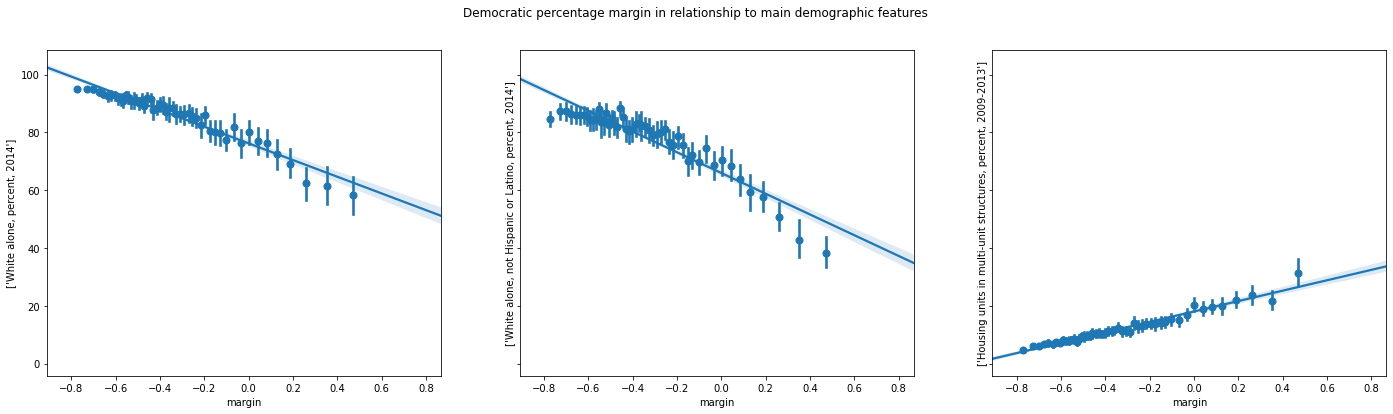

In [77]:
fig, axs = plt.subplots(ncols=3, figsize=(24,6), sharey=True)
for i in range(len(relevant_features)):
  ax = sns.regplot(data=data_democrat_county, y="margin", x=relevant_features[i], ax=axs[i], x_bins=50, ci=95)
  axs[i].set(xlabel=cfdict[relevant_features[i]])

plt.suptitle("Democratic percentage margin in relationship to main demographic features")
plt.show()

As we can see, support for democrats is lower the larger the proportion of the population is white in a county. This is a finding that is not particularly surprising and is in line with the broad expectations for each of the parties.

What's perhaps more interesting is what doesn't show up - democrats are broadly expected to have support from the educated, minority groups and urbanized, high density populations, but little of that seems to matter. It's perhaps possible that these features are simply not impactful enough on their own to affect the outcome, but Hillary had won the popular vote and so we would expect her base to be strongly represented in our results.

It's entirely possible that our results are being marred by the fact that we're treating counties as observations - it is possible, likely even, that there are more *people* that support the democrats but less *places*.

As expected, we can see that our data shows Hillary has lost in a vast majority of places. Since we know from prior knowledge that Hillary's results are at least comparable to Trump's, this is a reason to suspect that we should be careful how we interpret our data.

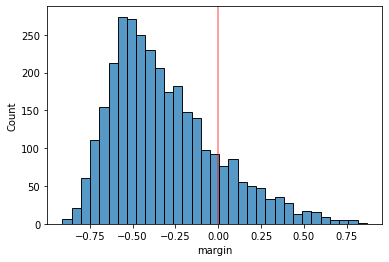

In [ ]:
sns.histplot(data=data[data["candidate"]=="Hillary Clinton"], x="margin")
plt.axvline(0, color="r", alpha=0.5)

Going back a bit, the strongest influence ffor a democrat outcome we see now seems to be a proxy for urbanization, specifically, what percentage of the county lives in multi-unit appartment buildings. It is strange that this does not show up in other ways.

We should do two things - try to disentagle our results from their by-county basis, and do PCA to perhaps extract information about features that are only active in a bundle.

### By state

In [ ]:
state_pe = pe.groupby(["state", "candidate", "party"], as_index=False)[["candidatevotes", "totalvotes"]].sum()
state_pe.head()

,state,candidate,party,candidatevotes,totalvotes
0,Alabama,Donald Trump,republican,1318250,2123367
1,Alabama,Hillary Clinton,democrat,729547,2123367
2,Alaska,Donald Trump,republican,163347,318056
3,Alaska,Hillary Clinton,democrat,116180,318056
4,Arizona,Donald Trump,republican,1252401,2628756


In [ ]:
state_pe["percentvotes"]= state_pe["candidatevotes"] / state_pe["totalvotes"]

margin_democrat = state_pe.loc[state_pe["party"] == "democrat", "percentvotes"].values - state_pe.loc[state_pe["party"] == "republican", "percentvotes"].values
state_pe.loc[state_pe["party"] == "democrat", "margin"] = margin_democrat

state_pe.loc[state_pe["party"] == "republican", "margin"] = -1*margin_democrat

state_pe = state_pe[state_pe["party"] != "Other"]

state_pe["absolutemargin"] = state_pe["margin"].abs()

In [ ]:
state_data = state_pe.merge(states, left_on="state", right_on="area_name")
state_data = state_data.drop(["fips", "area_name", "state_abbreviation"], axis=1)

In [ ]:
state_data = state_data.merge(electoral_college, left_on="state", right_on="state")

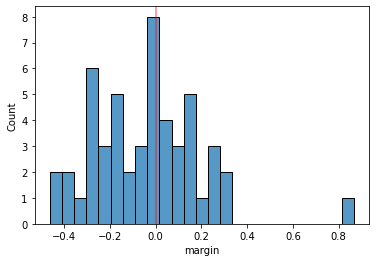

In [ ]:
sns.histplot(data=state_data[state_data["candidate"]=="Hillary Clinton"], x="margin", bins=25)
plt.axvline(0, color="r", alpha=0.5)

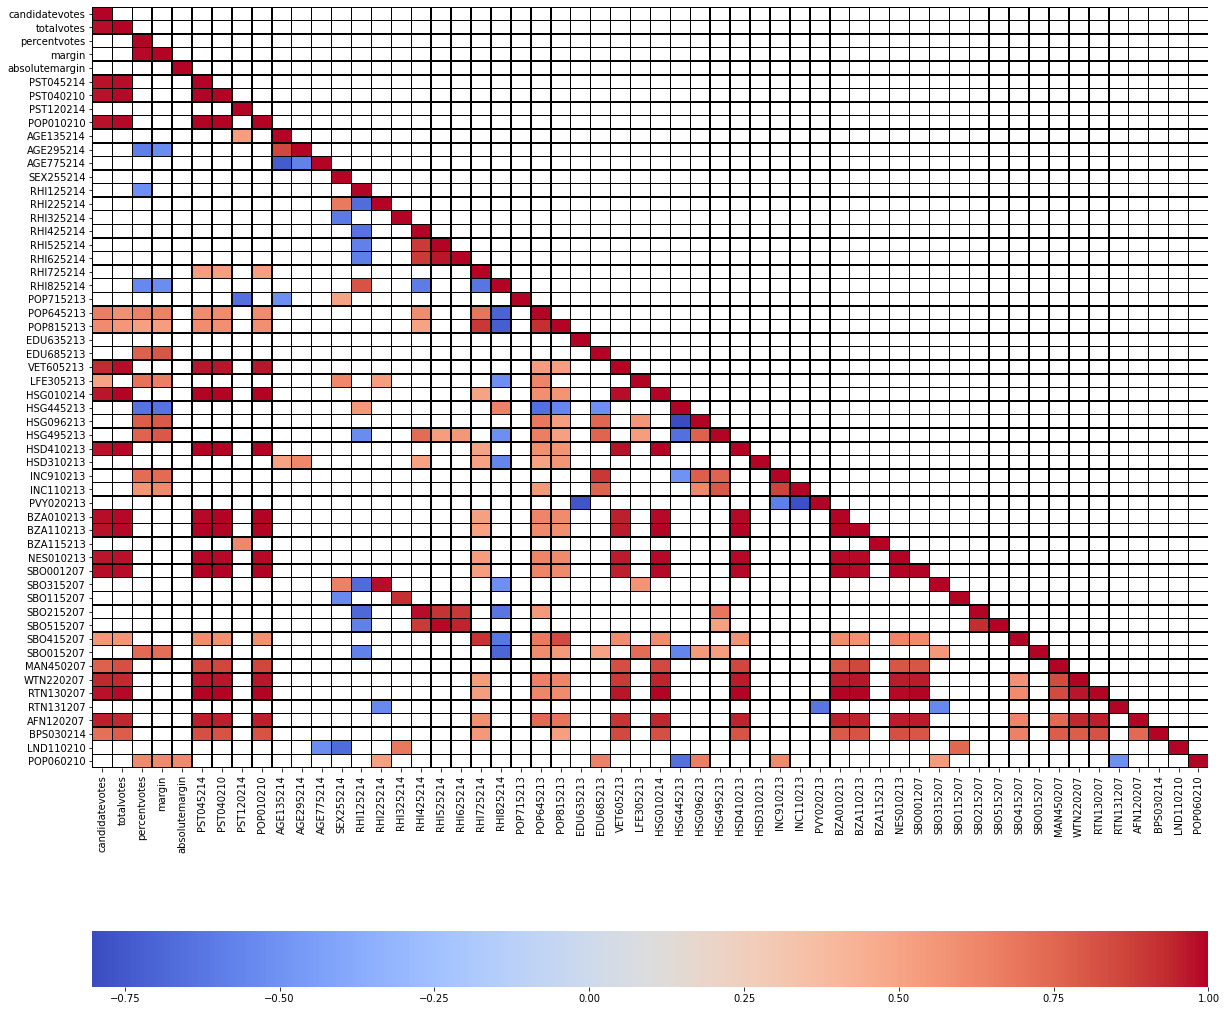

In [ ]:
data_demomcrat_state = state_data[state_data["party"] == "democrat"].loc[:,'candidatevotes':'POP060210']

corr = data_demomcrat_state.corr()
p_values = corr_sig(data_demomcrat_state)
mask = np.invert( np.tril(p_values<=0.05) & (corr.abs()>=0.5) )

plt.figure(figsize=(20,20))
sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm', linewidths=0.5, linecolor='black', cbar_kws={'orientation': 'horizontal'})

##earlier stuff

In [ ]:
electoral_college = electoral_college[electoral_college["Year"]==2016]
electoral_college.replace("D.C.", value="District of Columbia", inplace=True)
electoral_college.Votes = electoral_college.Votes.astype(int)
electoral_college.rename(columns={"Votes": "electorvotes"}, inplace=True)

In [ ]:
results_by_state = pe[["candidate", "party", "candidatevotes", "state"]].groupby(["state", "candidate", "party"], as_index=False)["candidatevotes"].sum()
state_winners= results_by_state.loc[results_by_state.groupby("state")["candidatevotes"].idxmax()]

states = states.merge(state_winners[["state","candidate", "party"]].rename(columns={"state":"State","candidate":"StateWinnerName", "party":"StateWinnerParty"}))
states.head()

In [ ]:
chart_order = list( states[states["StateWinnerParty"]=="republican"].sort_values("ElectorVotes", ascending=False).index.values )
chart_order += ( list( states[states["StateWinnerParty"]=="democrat"].sort_values("ElectorVotes", ascending=True).index.values ))

In [ ]:
chart_order = list( states[states["StateWinnerParty"]=="republican"].sort_values("ElectorVotes", ascending=False)["State"] )
chart_order += list( states[states["StateWinnerParty"]=="democrat"].sort_values("ElectorVotes", ascending=True)["State"] )

republicanred = "#ef8a62"
democratblue = "#67a9cf"

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=states, x="ElectorVotes", y="State",
            hue="StateWinnerParty",
            palette={"republican":republicanred, "democrat":democratblue},
            order=chart_order)

# Evaluation Criteria

- Code quality
- Fulfillment of the idea
- Adherence to the requirements
- Delivery of the presentation

Statistical hypothesis testing
- Correct statistical test method is used, based on the situation.
- Reasoning on chosen statistical significance level.

Modeling
- Both PCA and T-SNE algorithms are used.